# Classifying Chest X-Ray Images (Pneumonia)
### Markowitz Working NB

Dataset from https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

In [9]:
import os, shutil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

## Loading images from local folders

In [29]:
# Filepaths
train_dir = 'chest_xray/train'
validation_dir = 'chest_xray/val/'
test_dir = 'chest_xray/test/' 

In [30]:
# Check functionality and num images
train_normal_dir = os.path.join(train_dir, 'NORMAL')
train_pneumonia_dir = os.path.join(train_dir, 'PNEUMONIA')
train_normal_dir

'chest_xray/train/NORMAL'

In [31]:
print('There are', len(os.listdir(train_normal_dir)), 'normal images in the training set')
print('There are', len(os.listdir(train_pneumonia_dir)), 'pneumonia images in the training set')

There are 1341 normal images in the training set
There are 3875 pneumonia images in the training set


### EDA: Image Samples and Metadata

In [32]:
# Get list of filenames of all training images
train_norm_filenames = os.listdir(train_normal_dir)
train_pneum_filenames = os.listdir(train_pneumonia_dir)

In [33]:
# Make list of full filepaths to each image
train_normal_filepaths = [os.path.join(train_normal_dir, name) for name in train_norm_filenames]
train_pneumonia_filepaths = [os.path.join(train_pneumonia_dir, name) for name in train_pneum_filenames]

In [34]:
train_normal_filepaths[:10]

['chest_xray/train/NORMAL/NORMAL2-IM-0927-0001.jpeg',
 'chest_xray/train/NORMAL/NORMAL2-IM-1056-0001.jpeg',
 'chest_xray/train/NORMAL/IM-0427-0001.jpeg',
 'chest_xray/train/NORMAL/NORMAL2-IM-1260-0001.jpeg',
 'chest_xray/train/NORMAL/IM-0656-0001-0001.jpeg',
 'chest_xray/train/NORMAL/IM-0561-0001.jpeg',
 'chest_xray/train/NORMAL/NORMAL2-IM-1110-0001.jpeg',
 'chest_xray/train/NORMAL/IM-0757-0001.jpeg',
 'chest_xray/train/NORMAL/NORMAL2-IM-1326-0001.jpeg',
 'chest_xray/train/NORMAL/NORMAL2-IM-0736-0001.jpeg']

In [36]:
# Read each file in as an image
train_normal_images = [mpimg.imread(img) for img in train_normal_filepaths]
train_normal_images[0]

array([[ 0, 23, 24, ...,  0,  0,  0],
       [ 0,  5, 23, ...,  0,  0,  0],
       [ 1,  0, 26, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint8)

In [37]:
def get_images(filepath):
    '''
    Given a filepath for a folder of images, return a list of those images
    as arrays of dtype=uint8.
    '''
    # List of filenames
    filenames = os.listdir(filepath)
    # List of full filepaths to each image
    filepaths = [os.path.join(filepath, name) for name in filenames]
    # Return list of files as raw image arrays
    return [mpimg.imread(img) for img in filepaths]

In [38]:
# Get training images of normal and pneumonia
train_normal_images = get_images(train_normal_dir)
train_pneumonia_images = get_images(train_pneumonia_dir)

#### Show the first 5 images from each set:

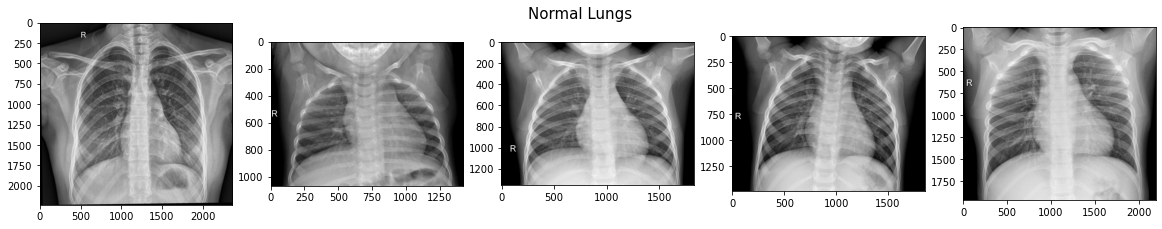

In [68]:
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

for i, ax in enumerate(axs):
    ax.imshow(train_normal_images[i], cmap='gray')
fig.suptitle('Normal Lungs', fontsize=15, y=.8)
fig.tight_layout;

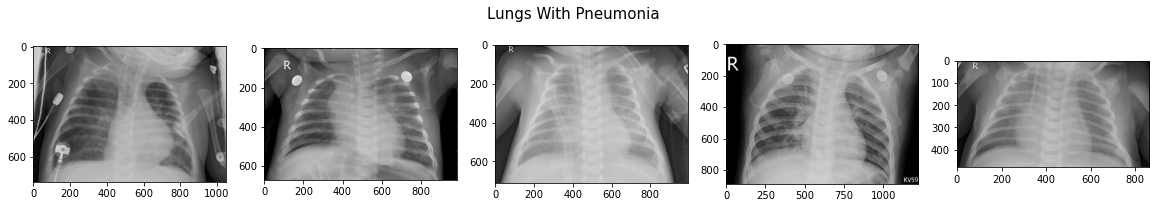

In [67]:
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

for i, ax in enumerate(axs):
    ax.imshow(train_pneumonia_images[i], cmap='gray')
fig.suptitle('Lungs With Pneumonia', fontsize=15, y=.8)
fig.tight_layout;

**Notes:**
 - All x-ray photos have 'R' to designate right-side lung
 - Pneumonia lungs have EKG(?) electrodes(?)--possible confounding factor for NN?
 - Pneumonia lungs look "cloudy" or "fuzzy" compared to Normal

From Kaggle:
> The normal chest X-ray (left panel) depicts clear lungs without any areas of abnormal opacification in the image. Bacterial pneumonia (middle) typically exhibits a focal lobar consolidation, in this case in the right upper lobe (white arrows), whereas viral pneumonia (right) manifests with a more diffuse ‘‘interstitial’’ pattern in both lungs.

Essentially, this means that bacterial pneumonia typically gathers in one area of the lungs, while viral penumonia is more spread out.

In [56]:
# Shape of images
normal_img_shapes = np.array([img.shape for img in train_normal_images])
pneumonia_img_shapes = np.array([img.shape for img in train_pneumonia_images])

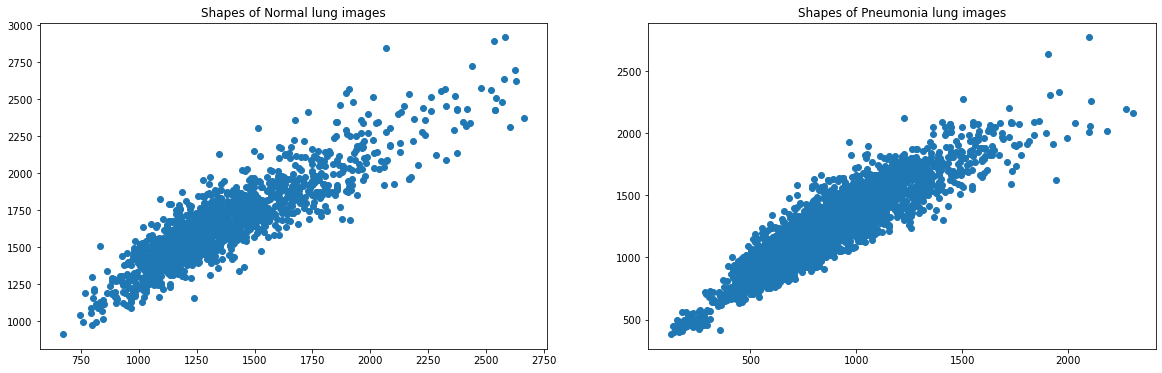

In [66]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Sizes of Normal lung images
ax1.scatter(x=[x[0] for x in normal_img_shapes], y=[x[1] for x in normal_img_shapes])
ax1.set_title('Shapes of Normal lung images')

# Sizes of Pneumonia lung images
ax2.scatter(x=[x[0] for x in pneumonia_img_shapes], y=[x[1] for x in pneumonia_img_shapes])
ax2.set_title('Shapes of Pneumonia lung images');